In [1]:
%config InlineBackend.figure_formats = ['retina']
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

# Load data

In [2]:
names = ['Ant', 'Grapes']

In [3]:
X_ant = np.load('./data/G_21_ant.npy')
X_grapes = np.load('./data/G_21_grapes.npy')

In [55]:
X_test = np.load('./data/test_images.npy')
y_test = np.load('./data/test_labels.npy')

Les data sets représentent des images dessinées en noir et blanc. Ils contiennent chacun $1000$ lignes et $784$ colonnes : $(1000, 784)$. Chaque colonne représente la couleur d'un pixel sur une échelle de gris de $0$ à $255$. Les $1000$ lignes correspondent à $1000$ images différentes. Les images ont une taille de $28\times28$, d'où les $784$ colonnes.

# Creates labels for ant and grapes

ant := label $0$ and grapes := label $1$

In [56]:
y_ant = np.zeros((X_ant.shape[0],))
y_grapes = np.ones((X_grapes.shape[0],))

# Merge the data into one matrix

In [57]:
X_train = np.concatenate((X_ant, X_grapes), axis=0)

In [58]:
y_train = np.concatenate((y_ant, y_grapes), axis=0)

# Shuffle train and test sets

In [59]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# Use SVM to separate data

## SVC with linear kernel

In [60]:
clf_lin = SVC(kernel='linear', C=1)
clf_lin.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [61]:
clf_lin.score(X_test, y_test)

0.717

## SVC with gaussian kernel

In [62]:
%%time
clf_rbf = SVC(kernel='rbf', C=2.5)
clf_rbf.fit(X_train, y_train)

CPU times: user 1.28 s, sys: 14.3 ms, total: 1.29 s
Wall time: 1.34 s


SVC(C=2.5)

In [63]:
clf_rbf.score(X_test, y_test)

0.873

### Use cross-validation to find the best parameters

In [79]:
%%time
clf_rbf_cv = GridSearchCV(SVC(kernel='linear'), param_grid={'C':np.logspace(-10,-8,10)})
clf_rbf_cv.fit(X_train, y_train)
print(clf_rbf_cv.best_params_)

{'C': 1e-08}
CPU times: user 1min 16s, sys: 714 ms, total: 1min 17s
Wall time: 1min 22s


In [80]:
clf_rbf_cv.cv_results_['mean_test_score']

array([0.8415, 0.8415, 0.8415, 0.8415, 0.8415, 0.841 , 0.8475, 0.851 ,
       0.851 , 0.854 ])

In [81]:
clf_rbf_cv.score(X_test, y_test)

0.844

# Use perceptron to separate the data

In [17]:
clf_p = Perceptron(tol=1e-3, random_state=1)
clf_p.fit(X_train, y_train)

Perceptron(random_state=1)

In [18]:
clf_p.score(X_test, y_test)

0.755

# Use PCA to reduce the dimension of the data

Before using PCA, we need to standardise the data (mean=0, variance=1)

In [19]:
# Standardise the X_train and X_test
X_s_train = StandardScaler().fit_transform(X_train)
X_s_test = StandardScaler().fit_transform(X_test)

In [20]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_s_train)
X_test_2d = pca.fit_transform(X_s_test)

In [21]:
clf_pca = SVC(kernel='rbf', C=1)
clf_pca.fit(X_2d, y_train)

SVC(C=1)

In [22]:
percep_pca = Perceptron(tol=1e-3, random_state=1)
percep_pca.fit(X_2d, y_train)

Perceptron(random_state=1)

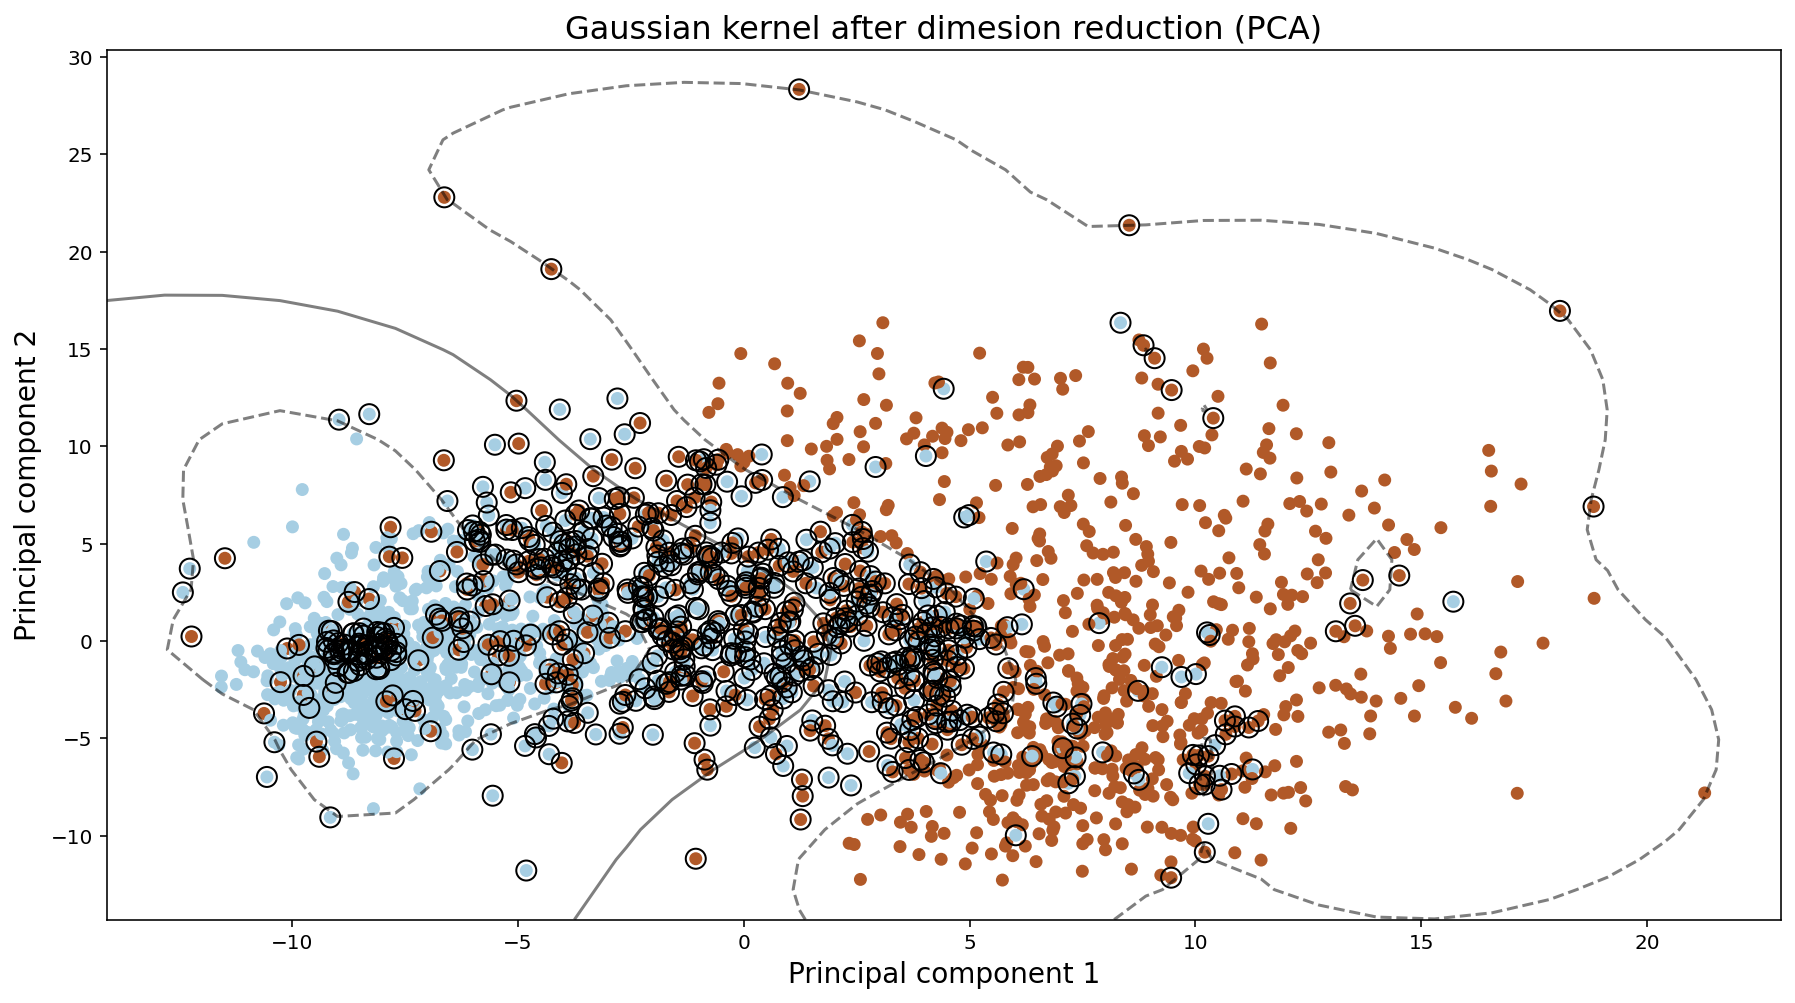

In [23]:
plt.figure(figsize=(15,8))
# plot the results in 2D to better understand the distribution of the data, plot with two different colors to see the classes
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_pca.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf_pca.support_vectors_[:, 0], clf_pca.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.title('Gaussian kernel after dimesion reduction (PCA)', size=16)
plt.xlabel('Principal component 1', size=14)
plt.ylabel('Principal component 2', size=14)
plt.show()

Donc les données ne semblent pas trop linéairement séparables, ce qui peut expliquer pourquoi on obtient le meilleur score avec le noyau gaussien 

In [24]:
clf_pca.score(X_test_2d, y_test)

0.815

# Test of several classification algorithms

## KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [26]:
neigh.score(X_test, y_test)

0.845

## Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
nb_clf= GaussianNB()
nb_clf.fit(X_train, y_train)

GaussianNB()

In [28]:
nb_clf.score(X_test, y_test)

0.783

## Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
dec_clf = DecisionTreeClassifier()
dec_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [30]:
dec_clf.score(X_test, y_test)

0.731

Dans l'ensemble tous les algorithmes sont moins bon que SVM avec gaussian kernel, y'a juste KNN qui a quand même un plutôt bon score, avec de la cross-validation on peut peut-être faire un truc bien sinon les autres pas sûr qu'ils soient super utiles.

## Neural network with no hidden layer

In [31]:
y_train_NN = to_categorical(y_train)
y_test_NN = to_categorical(y_test)

X_train = (X_train-np.mean(X_train, axis=1, keepdims=True))/np.std(X_train, axis=1, keepdims=True)

In [32]:
model = Sequential()
input_shape = 784
layer_1_shape = 300
output_shape = 2
model.add(Dense(layer_1_shape, activation='relu', input_dim=input_shape))
model.add(Dense(output_shape, activation='sigmoid'))

In [33]:
sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [34]:
%%time
epochs=10
history = model.fit(X_train, y_train_NN, epochs=epochs, batch_size=10, validation_data=(X_test, y_test_NN))

Epoch 1/10
200/200 [==============================] - 2s 6ms/step - loss: 0.5467 - accuracy: 0.7410 - val_loss: 21.0771 - val_accuracy: 0.8130
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3574 - accuracy: 0.8561 - val_loss: 21.5507 - val_accuracy: 0.8050
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2690 - accuracy: 0.8947 - val_loss: 20.8465 - val_accuracy: 0.8110
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2223 - accuracy: 0.9202 - val_loss: 23.3545 - val_accuracy: 0.7940
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1838 - accuracy: 0.9441 - val_loss: 28.9216 - val_accuracy: 0.7880
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1481 - accuracy: 0.9546 - val_loss: 24.7943 - val_accuracy: 0.8200
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1124 - accuracy: 0.9728 - val_loss: 28.2164 - val_accuracy: 0.7960

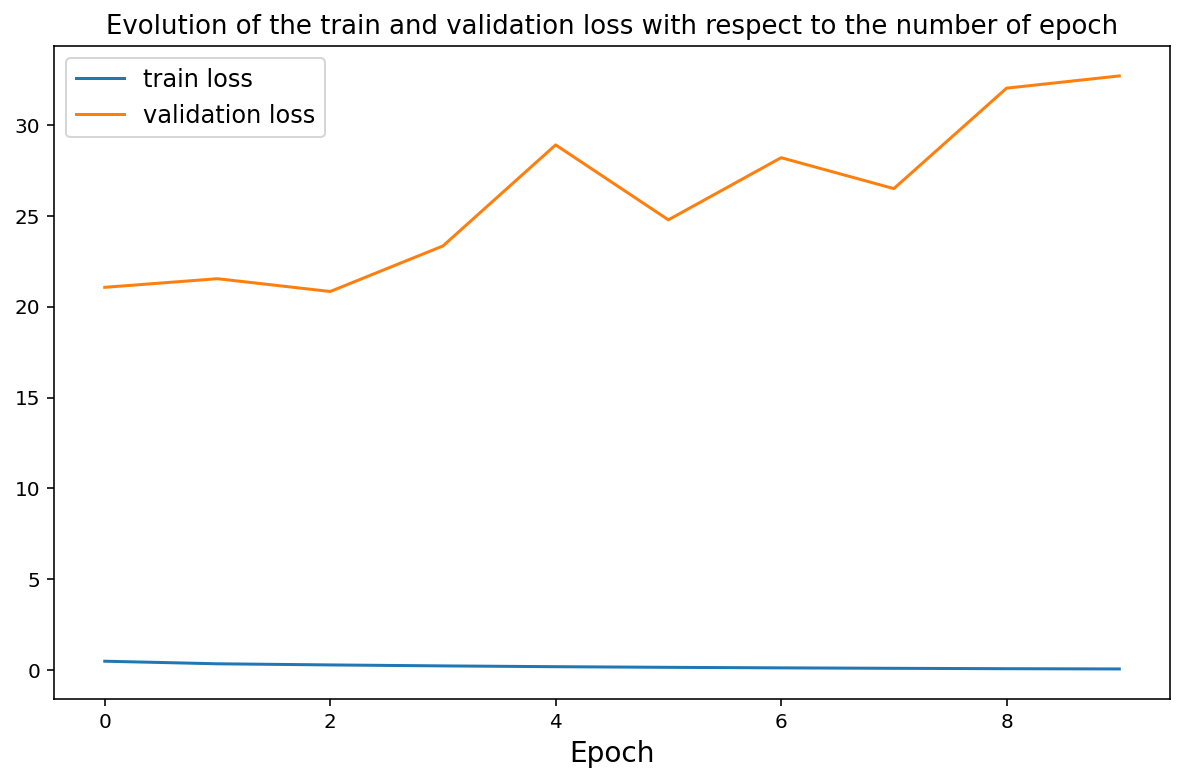

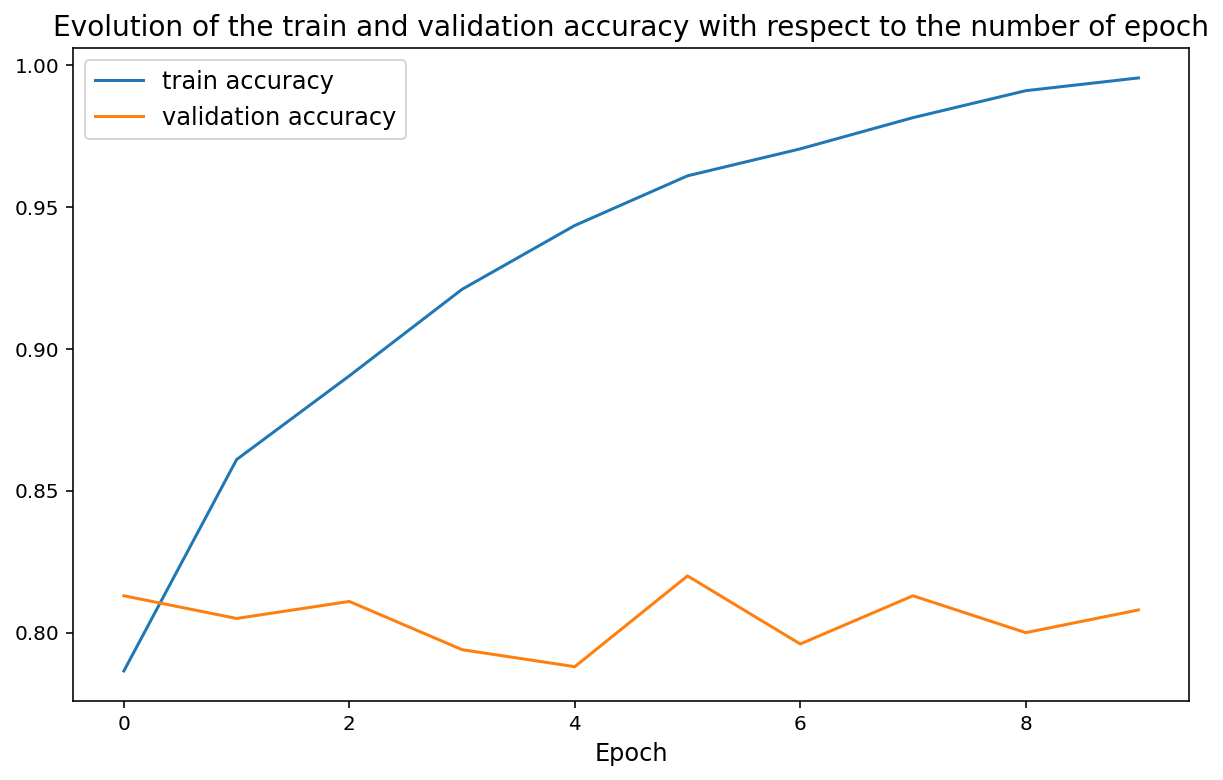

In [35]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch', size=14)
plt.title('Evolution of the train and validation loss with respect to the number of epoch', size=13)

plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(10,6))

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch', size=12)
plt.title('Evolution of the train and validation accuracy with respect to the number of epoch', size=14)

plt.legend(fontsize=12)
plt.show()